In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(1), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(1), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[-1, :, :])
        return out

# Custom dataset class
class PredictDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        # load write_counts column
        self.targets = data[:, 2]

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        target = self.targets[idx + self.window_size]
        target = torch.tensor(target)
        return torch.tensor(window), target

# Hyperparameters
input_size = 3  # read_time and period
hidden_size = 64
output_size = 1  # write_counts
learning_rate = 0.01
num_epochs = 15
batch_size = 16
window_size = 40

# Load dataset
# data = pd.read_csv('dataset.csv')
data = pd.read_csv('dataset.csv')
data = data[['read_time', 'period', 'write_counts']].values.astype(float)

# # Normalize data
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data = (data - data_mean) / data_std

# Split data into train and test sets
# train_size = int(0.8 * len(data))
train_data = data
test_data = data

# Create dataloaders
train_dataset = PredictDataset(train_data, window_size)
test_dataset = PredictDataset(test_data, window_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  7%|▋         | 1/15 [00:04<01:00,  4.33s/it]

Epoch [1/15], Loss: 0.7283


 13%|█▎        | 2/15 [00:08<00:51,  3.96s/it]

Epoch [2/15], Loss: 0.7112


 20%|██        | 3/15 [00:11<00:45,  3.79s/it]

Epoch [3/15], Loss: 0.7072


 27%|██▋       | 4/15 [00:15<00:40,  3.72s/it]

Epoch [4/15], Loss: 0.7050


 33%|███▎      | 5/15 [00:18<00:36,  3.65s/it]

Epoch [5/15], Loss: 0.7048


 40%|████      | 6/15 [00:22<00:32,  3.63s/it]

Epoch [6/15], Loss: 0.7037


 47%|████▋     | 7/15 [00:25<00:28,  3.62s/it]

Epoch [7/15], Loss: 0.7031


 53%|█████▎    | 8/15 [00:29<00:25,  3.60s/it]

Epoch [8/15], Loss: 0.7017


 60%|██████    | 9/15 [00:32<00:21,  3.55s/it]

Epoch [9/15], Loss: 0.7011


 67%|██████▋   | 10/15 [00:36<00:17,  3.53s/it]

Epoch [10/15], Loss: 0.7004


 73%|███████▎  | 11/15 [00:39<00:14,  3.53s/it]

Epoch [11/15], Loss: 0.6996


 80%|████████  | 12/15 [00:43<00:10,  3.54s/it]

Epoch [12/15], Loss: 0.6987


 87%|████████▋ | 13/15 [00:47<00:07,  3.54s/it]

Epoch [13/15], Loss: 0.6984


 93%|█████████▎| 14/15 [00:50<00:03,  3.52s/it]

Epoch [14/15], Loss: 0.6966


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]

Epoch [15/15], Loss: 0.6949


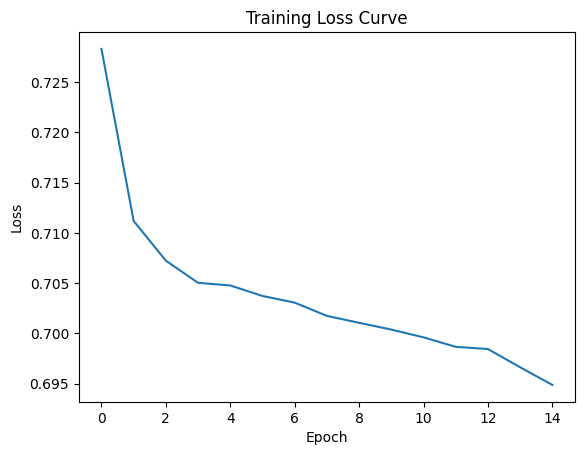

In [27]:

# Train the model
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.permute(1, 0, 2)  # Change shape to (seq_len, batch_size, input_size)
        inputs = inputs.float()
        targets = targets.float()
        targets = targets.view(-1, 1)
        outputs = model(inputs)
        # print(f"{targets=}, {outputs=}")

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [28]:
# Evaluate the model
model.eval()
predicted = []
true = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.permute(1, 0, 2)
        inputs = inputs.float()
        targets = targets.float()
        outputs = model(inputs)
        predicted.extend(outputs.cpu().numpy())
        true.extend(targets.cpu().numpy())
    #     total += targets.size(0)
    #     out2 = outputs.cpu().numpy()
    #     tar2 = targets.cpu().numpy()
    #     temp = out2 == tar2
    #     correct += temp.sum().item()
    # accuracy = 100 * correct / total
    # print('outputs.cpu().numpy():{:.2f}'.format(out2))
    # print('targets.cpu().numpy():{:.2f}'.format(tar2))
    # print('total:{:.2f}'.format(total))
    # print('Accuracy of the model on the test dataset: {:.2f} %'.format(accuracy))


In [29]:

# De-normalize data
# predicted = np.array(predicted)
# true = np.array(true)
predicted = np.array(predicted) * data_std[2] + data_mean[2]

# 创建一个 window_size行空值的数组
empty_values = np.empty((window_size, 1))
empty_values.fill(np.nan)

# 垂直堆叠 empty_values 到 predicted 数组中
predicted_new = np.vstack((empty_values, predicted))

df = pd.read_csv('dataset.csv')
df = df[['read_time', 'period', 'write_counts']]

# 将 predictions 添加到 DataFrame 中
df['predictions'] = predicted_new
df.to_csv('dataset.csv')

In [30]:
data2 = pd.read_csv('dataset.csv')
selected_columns = ['read_time', 'period', 'write_counts', 'predictions']
data2 = data2[selected_columns].values.astype(float)
total = 0
correct = 0
for index, (read_time, period, write_counts, predictions) in enumerate(data2):
    if predictions>0:
        predictions = round(predictions)
        total += 1
        correct += write_counts == predictions
accuracy = 100 * correct / total
print('Accuracy of the model on the test dataset: {:.2f} %'.format(accuracy))
    


Accuracy of the model on the test dataset: 21.55 %
